In [1]:
import os
import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import tensorflow as tf
import tensorflow_addons as tfa

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

def f_bits2array(bits):
  return [b*2**p for p,b in enumerate(np.flip(bits)) if b!=0]

def f_class_weights(yy):
  yy_labels,yy_counts = np.unique(yy,return_counts=True,axis=0)
  cc_weights = {i:0 for i in range(np.max(yy.ravel())+1)}
  yy_weights = len(yy)/(len(yy_labels)*yy_counts)
  cc_weights.update({yy_labels[i][0]:yy_weights[i] for i,l in enumerate(yy_labels)})
  return cc_weights

def f_binarize(num,length):
  rc = [0]*length; rc[num-1] = 1
  return rc

def f_binclass(y_dat):
  c_dat = np.argmax(y_dat,axis=1)
  n_dat = np.unique(c_dat)
  y_bcl = np.zeros((len(y_dat),len(n_dat)))

  for i,c in enumerate(n_dat):    
    y_bcl[c==c_dat,:] = f_binarize(i,len(n_dat))

  return y_bcl

def f_savefig(gname,gmetadata,gshow=False):
  plt.savefig(gname,dpi=plt.rcParams["figure.dpi"],metadata=gmetadata,bbox_inches="tight",pad_inches=.2)
  if gshow: plt.show()
  plt.close()
  

In [2]:
fpath = os.path.join(os.getcwd(),"data")
fprefix = "aug.0k"
fversion = "1"
fname = os.path.join(fpath,"data.1.%s.npz"%(fprefix))

fresult = os.path.join(os.getcwd(),"model","wisa.net.%s.%s"%(fprefix,fversion))

print("result:",fresult)

fmetadata = {"Title":fprefix,"Creation Time":datetime.datetime.now().strftime("%d.%m.%Y %H:%M:%S")}

data = np.load(fname)

X = data['arr_0']
y = data['arr_1']

# small anomaly removal
X[X==3] = 2

X_raw = X.copy()
y_raw = y.copy()

types = np.arange(y.sum(axis=1).max()+1)
y = np.packbits(y,axis=1)

y_index = {n:i for i,n in enumerate(np.unique(y))}
y = np.array([[y_index[n]] for n in y.flatten()])

label_index = {y_index[k]:k for k in y_index.keys()}

labels,counts = np.unique(y,return_counts=True,axis=0)
c_weights = f_class_weights(y)

result: c:\Develop\vsc\wisa\develop\model\wisa.net.aug.0k.1


In [3]:
assemblies = []
for t in types:    
  ll = np.unique(y_raw[np.where(y_raw.sum(axis=1)==t)[0]],axis=0)  
  for l in ll:    
    index = np.argwhere(np.packbits(y_raw,axis=1)==np.packbits(l))[:,0]
    assemblies.append(
      dict(
        type=t,label=l,
        number=np.packbits(l)[0],
        number_index=y_index[np.packbits(l)[0]],
        index=index,
        assembly=f_bits2array(l),
        bin=len(index)
      ))

assemblies = pd.DataFrame(assemblies)
assemblies = assemblies.sort_values(by=["type","number"])

assemblies.loc[:,~assemblies.columns.isin(["index"])].to_csv(os.path.join(fresult,"%s.model.assemblies.csv"%(fprefix)),index=False)

In [4]:

def build_samples_():

    samples = []

    n_index = 0
    for t in types:
        view = assemblies[assemblies["type"]==t]
        nn = np.unique(view["number"].to_numpy())    
        for n in nn:
            index = view.loc[view["number"]==n,"index"].to_numpy()[0]
            samples.append(
                dict(
                    type=t,
                    number=n,
                    sample=X[index[n_index],:,:].copy()
                )
            )
    return pd.DataFrame(samples)

samples = build_samples_()

# -----------------------------

def plot_samples_(samples,postfix="n"):

    n_bin = samples.shape[0]

    n_cols = 8
    n_rows = int(np.ceil(n_bin/n_cols))

    n_cmp = [plt.cm.Greys,plt.cm.Blues,plt.cm.Purples,plt.cm.Greens,plt.cm.Oranges]

    plt.rcParams["font.size"] = 8
    plt.rcParams["figure.dpi"] = 80

    n_width,n_height = 2,2

    fig = plt.figure(figsize=[n_width*n_cols,n_height*n_rows],dpi=plt.rcParams["figure.dpi"])

    k = 1
    for t in types:
        view = samples[samples["type"]==t]
        nn = view["number"].to_numpy()
        for n in nn:            
            assembly = assemblies.loc[(assemblies["type"]==t)&(assemblies["number"]==n),"assembly"].to_numpy()[0]        
            sample = view.loc[view["number"]==n,"sample"].to_numpy()[0].copy()
            ax = plt.subplot(n_rows,n_cols,k)
            ax.imshow(sample,cmap=n_cmp[t])
            ax.set_title("%02d:%03d %s"%(t,n,assembly),x=0,ha="left")

            ax.set_axis_off()
            k += 1

    plt.tight_layout()
    f_savefig(os.path.join(fresult,"%s.samples.%s.png"%(fprefix,postfix)),fmetadata,gshow=False)

# -----------------------------

def plot_items_(items,fpath="",fpostfix="n",fshow=False):

    n_bin = items.shape[0]

    n_cols = 6
    n_rows = int(np.ceil(n_bin/n_cols))

    n_cmp = [plt.cm.Greys,plt.cm.Blues,plt.cm.Purples,plt.cm.Greens,plt.cm.Oranges]

    plt.rcParams["font.size"] = 8
    plt.rcParams["figure.dpi"] = 80

    n_width,n_height = 2,2

    fig = plt.figure(figsize=[n_width*n_cols,n_height*n_rows],dpi=plt.rcParams["figure.dpi"])

    k = 1
    for s in range(n_bin):
        item = items.loc[s,:]
        t = item["type"]
        n = item["number"]
        assembly = assemblies.loc[(assemblies["type"]==t)&(assemblies["number"]==n),"assembly"].to_numpy()[0]
        sample = item["sample"]
            
        ax = plt.subplot(n_rows,n_cols,k)
        ax.imshow(sample,cmap=n_cmp[t])
        ax.set_title("%02d:%03d %s"%(t,n,assembly),x=0,ha="left")

        ax.set_axis_off()
        k += 1

    plt.tight_layout()
    f_savefig(os.path.join(fresult,fpath,"%s.samples.%s.png"%(fprefix,fpostfix)),fmetadata,gshow=fshow)

# -----------------------------    

def plot_item_(item,fpath="",fpostfix="x",fshow=False):

    n_cols = 1
    n_rows = 1

    n_cmp = [plt.cm.Greys,plt.cm.Blues,plt.cm.Purples,plt.cm.Greens,plt.cm.Oranges]

    plt.rcParams["font.size"] = 8
    plt.rcParams["figure.dpi"] = 80

    n_width,n_height = 5,5

    _ = plt.figure(figsize=[n_width*n_cols,n_height*n_rows],dpi=plt.rcParams["figure.dpi"])

    k = 1

    t = item["type"]
    n = item["number"]
    assembly = assemblies.loc[(assemblies["type"]==t)&(assemblies["number"]==n),"assembly"].to_numpy()[0]
    sample = item["sample"]
            
    ax = plt.subplot(n_rows,n_cols,k)
    ax.imshow(sample,cmap=n_cmp[t])
    ax.set_title("%02d:%03d %s"%(t,n,assembly),x=0,ha="left")

    ax.set_axis_off()

    plt.tight_layout()
    f_savefig(os.path.join(fresult,fpath,"%s.sample.%s.png"%(fprefix,fpostfix)),fmetadata,gshow=fshow)    

plot_samples_(samples)
plot_item_(samples.loc[15,:],fshow=False)

In [5]:
def plot_weights_(fweights,fshow=False):

    plt.rcParams["font.size"] = 8
    plt.rcParams["figure.dpi"] = 80

    ticks = np.arange(len(labels.ravel()))
    ticklabels = ["%03d"%(label_index[label]) for label in labels.ravel()]

    heights = [fweights[label] for label in labels.ravel()]

    nrows,ncols = 1,1
    fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=[12*ncols,4*nrows],dpi=plt.rcParams["figure.dpi"])

    bottom = 1.5
    ax.bar(ticks,height=heights,bottom=bottom,color=[(192/255,0,0,1)])

    ax.set_xticks(ticks)
    ax.set_xticklabels(ticklabels,rotation=90)
    ax.set_xlabel("label")
    ax.set_ylabel("weight [%]")

    for an in assemblies[["number_index","bin"]].to_numpy():
        ax.annotate("%d"%(an[1]),xy=(an[0],1.25),rotation=90,va="top",ha="center")

    ax.set_title("weight of label(class) computed by count(class)",x=0,ha="left")

    yticks = np.arange(10)

    ax.set_yticks(yticks)
    ax.set_yticklabels([str(t-bottom) if (t-bottom)>=0 else "" for t in yticks])

    f_savefig(os.path.join(fresult,"%s.label.weight.png"%(fprefix)),fmetadata,gshow=fshow)

plot_weights_(c_weights,fshow=False)

In [6]:
# qualities: basic statistics

pips_range = range(0,3)
pips = []

for t in types:
    nn = assemblies.loc[assemblies["type"]==t,"number"].to_numpy()
    for n in nn:        
        index = assemblies.loc[assemblies["number"]==n,"index"].to_numpy()[0]        
        pip = dict(type=t,number=n)
        values,counts = np.unique(X_raw[index,:,:],return_counts=True)
        for i,c in enumerate(values): pip["c%d"%(c)] = counts[i]
        pips.append(pip)

pips = pd.DataFrame(pips)
pips = pips.fillna(value=0)

for c in pips_range: pips["c%d"%(c)] = pips["c%d"%(c)].astype(np.int64)
pips["csum"] = pips[["c%d"%(value) for value in pips_range]].sum(axis=1)
for c in pips_range: pips["p%d"%(c)] = pips["c%d"%(c)]/pips["csum"]

pips["assembly"] = assemblies.loc[pips["number"]==assemblies["number"],"assembly"]

In [7]:
def plot_pips_(pips,mode="p"):

    plt.rcParams["font.size"] = 8
    plt.rcParams["figure.dpi"] = 80

    nrows,ncols = 1,1

    fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=[12*ncols,4*nrows],dpi=plt.rcParams["figure.dpi"])

    size = pips.shape[0]
    xticks = np.arange(size)
    xticklabels = ["%03d"%(pips.loc[n,"number"]) for n in xticks]
    annotlabels = ["%s"%(pips.loc[n,"assembly"]) for n in xticks]

    bottom = [0]*size
    for c in pips_range:
        bottom = bottom + pips["%s%d"%(mode,c-1)] if c>0 else bottom
        height = pips["%s%d"%(mode,c)].to_numpy()
        ax.bar(xticks,height=height,bottom=bottom,label="%d"%(c),color=plt.cm.Blues(c*.33),width=0.6)
        
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels,rotation=90)

    sx = ax.secondary_xaxis("top",)
    sx.set_xticks(xticks,loc="top")
    sx.set_xticklabels(annotlabels,rotation=90)

    ax.legend(bbox_to_anchor=(1.,1),title="pips")
    ax.set_xlabel("label")
    ax.set_ylabel("pips [%%] (mode:%s)"%(mode))

    ax.set_ylim([-.2,1.2])

    ax.set_title("mean of pips per label",x=0,ha="left")

    size = pips.groupby(by=["type"]).agg({"number":"count"}).to_dict()["number"]

    xy,h = [-.5,-.1],1.2
    a,z = .2,-1

    for k in size.keys():
        w = size[k]
        ax.add_patch(Rectangle(xy=xy,width=w,height=h,alpha=a,zorder=z,color=plt.cm.Greys(0.5*(k%2+1)),antialiased=False,linewidth=0))
        ax.annotate("%d"%(k),xy=(xy[0]+.04,xy[1]+.025))
        xy[0] = xy[0] + w

    f_savefig(os.path.join(fresult,"%s.label.pip.png"%(fprefix)),fmetadata,gshow=False)

plot_pips_(pips,mode="p")

In [8]:
size,w,h = X.shape

X_ = X.astype('float32')
X_ = (X_-X_.min())/(X_.max()-X_.min())

X_train,X_test,y_train,y_test = train_test_split(X_,y,test_size=0.2,random_state=42)
X_test,X_valid,y_test,y_valid = train_test_split(X_test,y_test,test_size=0.5,random_state=42)

X_train = X_train.reshape(X_train.shape[0],w,h,1)
X_test = X_test.reshape(X_test.shape[0], w,h, 1)
X_valid = X_valid.reshape(X_valid.shape[0], w,h, 1)

input_shape = (w,h,1)
output_shape = np.max(np.unique(y_train))+1

c_train_weights = f_class_weights(y_train)
c_test_weights = f_class_weights(y_test)
c_valid_weights = f_class_weights(y_valid)

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
y_valid = tf.keras.utils.to_categorical(y_valid)


In [9]:
# N_out = ([N_input + 2*padding - kernel_size]/stride) + 1

kernel_size = (3,3)
strides = (1,1)
pool_size = (2,2)
rate = 0.25

model = tf.keras.models.Sequential([
  
  tf.keras.layers.Conv2D(filters=32,kernel_size=kernel_size,strides=strides,activation='relu',kernel_initializer='he_uniform',name="conv00",input_shape=input_shape),
  tf.keras.layers.MaxPooling2D(pool_size=pool_size,name="pooling00"),
  
  tf.keras.layers.Conv2D(filters=64,kernel_size=kernel_size,strides=strides,activation='relu',kernel_initializer='he_uniform',name="conv01"),
  tf.keras.layers.MaxPooling2D(pool_size=pool_size,name="pooling01"),
  
  tf.keras.layers.Flatten(name="flatten00"),

  tf.keras.layers.Dense(units=128,activation='relu',kernel_initializer='he_uniform',name="upsampling00"), 
  
  tf.keras.layers.Dropout(rate=rate,name="dropout00"), 

  tf.keras.layers.Dense(units=output_shape,activation='softmax',name="output00")

],name="model")

# -------------------------

loss = tf.keras.losses.CategoricalCrossentropy(name="loss")

# -------------------------
    
N = y_train.shape[0]
num_classes = y_train.shape[1]

epochs = 25
batch_size = 64

initial_learning_rate=0.01
decay_steps = 2 * N // batch_size

# -------------------------

model_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=0.98,
    staircase=True,
    name="decay"
)

momentum = 0.9

optimizer = tf.keras.optimizers.SGD(
  learning_rate=model_schedule,
  momentum=momentum
)

# -------------------------

model.compile(optimizer=optimizer, loss=loss, 
    metrics=[
      tf.keras.metrics.CategoricalAccuracy(name="acc"),
      tf.keras.metrics.AUC(name="auc"),
      tf.keras.metrics.Precision(name="pre"),
      tf.keras.metrics.Recall(name="rec"),
      tfa.metrics.F1Score(name="f1s",num_classes=num_classes,average="weighted"),
      tfa.metrics.CohenKappa(name="kap",num_classes=num_classes)
    ])

# -------------------------

with open(os.path.join(fresult,"%s.model.summary.txt"%(fprefix)),'w') as f:
  model.summary(print_fn=lambda x: f.write(x + '\n'))  
  f.write("\n--- Optimizer\n")
  f.write("\n".join(["%s: %s"%(k,str(optimizer.get_config()[k])) for k in optimizer.get_config().keys()]))
  f.write("\n--- Loss\n")
  f.write("\n".join(["%s: %s"%(k,str(loss.get_config()[k])) for k in loss.get_config().keys()]))


In [10]:
class ModelCallback(tf.keras.callbacks.Callback):

    learning_rate = []

    def __init__(self):
        super().__init__()
        self.learning_rate = []

    def on_epoch_begin(self, epoch, logs=None):
        self.learning_rate.append(self.model.optimizer._decayed_lr(tf.float32).numpy())
        print("Learning rate %f by %s steps"%(self.learning_rate[-1],self.model.optimizer.learning_rate.get_config()["decay_steps"]))
        return super().on_epoch_begin(epoch, logs)

    def on_epoch_end(self, epoch, logs=None):        
        return super().on_epoch_end(epoch, logs)

model_callback = ModelCallback()

In [11]:
mpath = os.path.join(os.getcwd(),"model","wisa.net.%s.%s.%d.h5"%(fprefix,fversion,epochs))

mtrain = False

if True==mtrain:
  history = model.fit(
                X_train,y_train,
                epochs=epochs,                
                batch_size=batch_size,
                validation_data=(X_valid,y_valid),
                class_weight=c_train_weights,
                verbose=1,                
                callbacks=[model_callback]
    )
  history = history.history
  model.save(mpath,include_optimizer=True)
  np.save(mpath+".history",history)
  np.save(mpath+".callback",[model_callback.learning_rate])

In [12]:
model = tf.keras.models.load_model(mpath,
    custom_objects={
        "f1s":tfa.metrics.F1Score(name="f1s",num_classes=num_classes,average="weighted"),
        "kap":tfa.metrics.CohenKappa(name="kap",num_classes=num_classes)
    }
)
history = np.load(mpath+".history.npy",allow_pickle=True).item()
model_callback.learning_rate = list(np.load(mpath+".callback.npy",allow_pickle=True)[0])

In [13]:
ylr = model_callback.learning_rate
xlr = np.arange(len(ylr))

xticks = xlr
xticklabels = ["%02d"%(t+1) for t in xticks]

plt.rcParams["font.size"] = 8
plt.rcParams["figure.dpi"] = 80

ncols = 1
nrows = 1

fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=[10*ncols,3*nrows])

ax.plot(xlr,ylr,"o:",ms=2)

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

ax.set_xlabel("epoch")
ax.set_ylabel("learning rate")

ax.set_title("learning rate decay",x=0,ha="left")

plt.tight_layout()
f_savefig(os.path.join(fresult,"%s.model.decay.png"%(fprefix)),fmetadata,gshow=False)

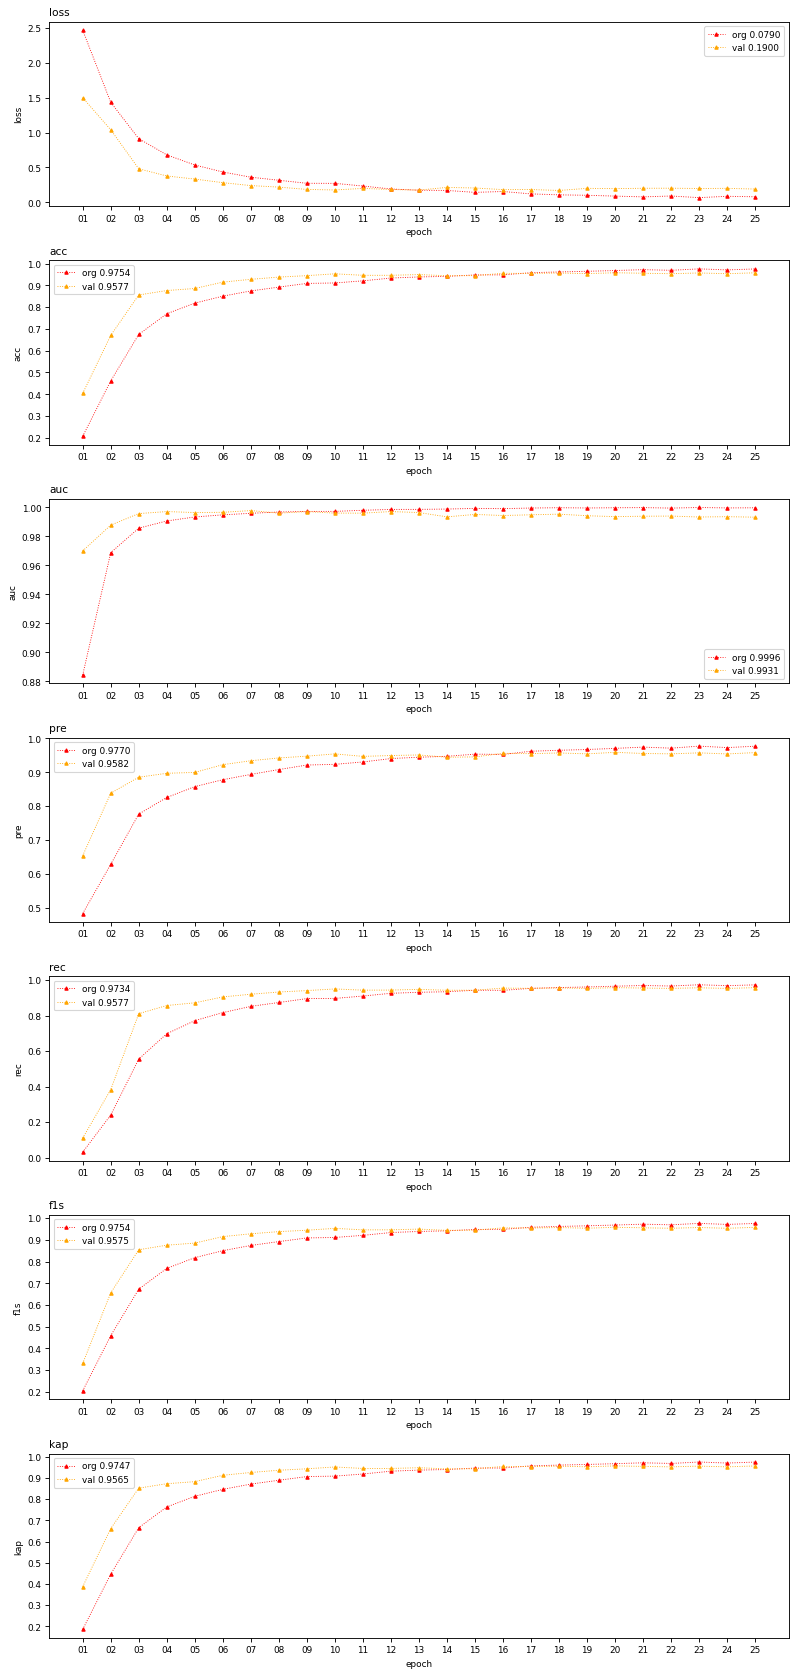

In [15]:
keys = [k for k in list(history.keys()) if not k.startswith("val_")]

plt.rcParams["font.size"] = 8
plt.rcParams["figure.dpi"] = 80

titles = keys

ncols = 1
nrows = len(keys)

fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=[10*ncols,3*nrows])

xticks = np.arange(len(history["loss"]))
xticklabels = ["%02d"%(t+1) for t in xticks]

j = 0
for k in keys:
  ax[j].plot(xticks,history[k],"^:",ms=3,lw=.8,c="red",label="org %.4f"%(history[k][-1]))  
  k = "val_%s"%(k)
  if k in list(history.keys()): ax[j].plot(xticks,history[k],"^:",ms=3,lw=.8,c="orange",label="val %.4f"%(history[k][-1]))
  j += 1

for i,a in enumerate(ax.ravel()):
  a.set_xlabel("epoch")  
  a.set_xticks(xticks)
  a.set_xticklabels(xticklabels)  
  if i<len(titles):
    a.legend()
    a.set_title(titles[i],x=0,ha="left")
    a.set_ylabel(titles[i])
  else:
    a.set_axis_off()

plt.tight_layout()
f_savefig(os.path.join(fresult,"%s.model.metrics.png"%(fprefix)),fmetadata,gshow=True)

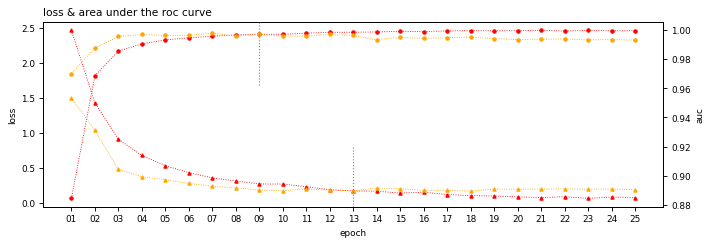

In [16]:
plt.rcParams["font.size"] = 8
plt.rcParams["figure.dpi"] = 80

ncols = 1
nrows = 1

fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=[10*ncols,3*nrows])

xticks = np.arange(len(history["loss"]))
xticklabels = ["%02d"%(t+1) for t in xticks]

k = "loss"
ax.plot(xticks,history[k],"^:",ms=3,lw=.8,c="red",label="org %.4f"%(history[k][-1])) 
k = "val_loss"
ax.plot(xticks,history[k],"^:",ms=3,lw=.8,c="orange",label="val %.4f"%(history[k][-1])) 
ax.set_ylabel("loss")

ax2 = ax.twinx()
k = "auc"
ax2.plot(xticks,history[k],"o:",ms=3,lw=.8,c="red",label="org %.4f"%(history[k][-1])) 
k = "val_auc"
ax2.plot(xticks,history[k],"o:",ms=3,lw=.8,c="orange",label="val %.4f"%(history[k][-1])) 
ax2.set_ylabel("auc")

ax.set_xlabel("epoch")  
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)  

ax.set_title("loss & area under the roc curve",x=0,ha="left")

ax.axvline(x=12,linestyle=":",linewidth=1,color="gray",ymax=.33)
ax2.axvline(x=8,linestyle=":",linewidth=1,color="gray",ymin=.66)

plt.savefig(os.path.join(fresult,"%s.loss.auc.png"%(fprefix)))
plt.show()
plt.close()

In [17]:
y_pred = model.predict(X_test,verbose=1,batch_size=batch_size)

60/60 [==============================] - 2s 27ms/step


In [18]:
# actual labeling
c_test = np.argmax(y_test,axis=1).astype(np.uint8)
# predicted labeling
c_pred = np.argmax(y_pred,axis=1).astype(np.uint8)

C = confusion_matrix(c_test,c_pred,normalize="true")*100

sample_weight = np.ones_like(c_pred).astype(np.float32)
for k in c_test_weights.keys(): sample_weight[c_pred==k] = c_test_weights[k]

Cw = confusion_matrix(c_test,c_pred,normalize="true",sample_weight=sample_weight)*100 

In [220]:
from matplotlib.colors import LinearSegmentedColormap

nn = C.shape[0]

xticks = np.arange(nn)
yticks = xticks
xticklabels = ["%03d"%(label_index[n]) for n in range(nn)]
yticklabels = xticklabels

title = "epochs %d | batch size %d"%(epochs,batch_size)

plt.rcParams["font.size"] = 8
plt.rcParams["figure.dpi"] = 80

nrows,ncols = 4,2

fig = plt.figure(figsize=[ncols*6,12], dpi=plt.rcParams["figure.dpi"])

# ---------------------------

ax = plt.subplot2grid(shape=(nrows,ncols),loc=(0,0),rowspan=2,fig=fig)

map = ax.imshow(C,origin="upper",cmap=plt.cm.Greens,vmin=0,vmax=100)
ax.set_ylabel("actual(label)")

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation=90)
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels,rotation=0)

ax.set_title(title,x=0,ha="left")

for n in range(nn):
  ax.annotate("%03d"%(C[n,n]),xy=(n+.15,(n+.5 if n<nn/2 else n-1)),va=("top" if n<nn/2 else "bottom"),ha="center",rotation=90)

ax.grid(alpha=0.2,linestyle="--")

# ---------------------------

ax = plt.subplot2grid(shape=(nrows,ncols),loc=(0,1),rowspan=2,fig=fig)

map = ax.imshow(Cw,origin="upper",cmap=plt.cm.Reds,vmin=0,vmax=100)
ax.set_ylabel("actual(label)")

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation=90)
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels,rotation=0)

ax.set_title("%s [weighted]"%(title),x=0,ha="left")

for n in range(nn):
  ax.annotate("%03d"%(Cw[n,n]),xy=(n+.15,(n+.5 if n<nn/2 else n-1)),va=("top" if n<nn/2 else "bottom"),ha="center",rotation=90)

ax.grid(alpha=0.2,linestyle="--")

# ---------------------------

ax = plt.subplot2grid(shape=(nrows,ncols),loc=(2,0),rowspan=1,fig=fig)

cd = C.diagonal()
cc = np.array([(0,c/255.,0,1.) for c in cd])

w_ = 1.
ax.bar(xticks,height=cd,width=w_,color=cc)

for n in range(nn):
  ax.annotate("%03d"%(C[n,n]),xy=(n,cd[n]),ha="center",va="top",rotation=90,color="w")

ax.set_xlim([xticks[0]-w_/2,xticks[-1]+w_/2])

ax.set_xlabel("prediction(label)")
ax.set_ylabel("accuracy [%]")
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation=90)

ax.grid(alpha=0.2,linestyle="--")

# ---------------------------

ax = plt.subplot2grid(shape=(nrows,ncols),loc=(2,1),rowspan=1,fig=fig)

cd = Cw.diagonal()
cc = np.array([(c/255.,0,0,1.) for c in cd])

w_ = 1.
ax.bar(xticks,height=cd,width=w_,color=cc)

for n in range(nn):
  ax.annotate("%03d"%(Cw[n,n]),xy=(n,cd[n]),ha="center",va="top",rotation=90,color="w")

ax.set_xlim([xticks[0]-w_/2,xticks[-1]+w_/2])

ax.set_xlabel("prediction(label)")
ax.set_ylabel("accuracy [%]")
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation=90)

ax.grid(alpha=0.2,linestyle="--")

# ---------------------------

ax = plt.subplot2grid(shape=(nrows,ncols),loc=(3,0),rowspan=1,fig=fig)

keys = [k for k in list(history.keys()) if not k.startswith("val_")]

vv = [(k,history[k][-1],history["val_%s"%(k)][-1]) for k in keys]

ax.table(
  cellText=[[v[0],"%.4f"%(v[1]),"%.4f"%(v[2])] for v in vv],
  
  rowLabels=None,
  rowLoc=None,
  
  colLabels=["","org","val"],
  colWidths=[0.2,0.74,0.74],
  colLoc="left",

  cellLoc="left",
  
  loc="upper left",
  bbox=[0.,0.,1.,1.] 
)
ax.set_axis_off()

# ---------------------------

ax = plt.subplot2grid(shape=(nrows,ncols),loc=(3,1),rowspan=1,fig=fig)

ww = np.array([c_test_weights[label] for label in labels.ravel()])

cmap = plt.cm.Reds
urange = np.linspace(0,1,num=len(ww),endpoint=True)
ucolors = [(c,cmap(c)) for c in urange]
umap = LinearSegmentedColormap.from_list("umap",ucolors, N=len(ww))

cc = np.array([umap(c) for c in ww/ww.max()])

w_ = 1.
ax.bar(xticks,height=ww,width=w_,color=cc)

ax.set_xlim([xticks[0]-w_/2,xticks[-1]+w_/2])

ax.set_xlabel("prediction(label)")
ax.set_ylabel("weight(test)")
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation=90)

# ---------------------------

plt.tight_layout(pad=.5)
f_savefig(os.path.join(fresult,"%s.model.covariance.%d.%d.png"%(fprefix,epochs,batch_size)),fmetadata,gshow=False)


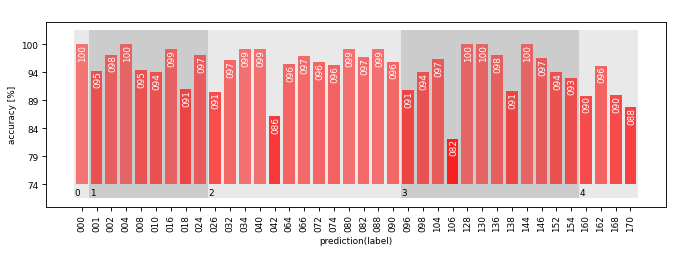

In [22]:
from matplotlib.patches import Rectangle

plt.rcParams["font.size"] = 8
plt.rcParams["figure.dpi"] = 80

ncols = 1
nrows = 1

fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=[10*ncols,3*nrows])

nn = C.shape[0]

xticks = np.arange(nn)
xticklabels = ["%03d"%(label_index[n]) for n in range(nn)]

cd = Cw.diagonal()

cd_min = cd.min()*.9
cd_max = cd.max()

cd = (cd-cd_min)/(cd_max-cd_min)

cc = np.array([(1.,0,0,.5+.5*(1.-c)) for c in cd])

ax.bar(xticks,height=cd,color=cc)

for n in range(nn):
  ax.annotate("%03d"%(Cw[n,n]),xy=(n+.08,cd[n]),ha="center",va="top",rotation=90,color="w")

size = assemblies.groupby(by=["type"]).agg({"number":"count"}).to_dict()["number"]
xy,h = [-.5,-.1],1.2
a,z = .2,-1
for k in size.keys():
    w = size[k]
    ax.add_patch(Rectangle(xy=xy,width=w,height=h,alpha=a,zorder=z,color=plt.cm.Greys(0.5*(k%2+1)),antialiased=False,linewidth=0))
    ax.annotate("%d"%(k),xy=(xy[0]+.04,xy[1]+.025))
    xy[0] = xy[0] + w

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation=90)

yticks = ax.get_yticks()

yticklabels = ["%d"%(((y_*(cd_max-cd_min)+cd_min))) for y_ in yticks]
ax.set_yticklabels(yticklabels)

ax.set_title(" ",x=0,ha="left")

ax.set_xlabel("prediction(label)")
ax.set_ylabel("accuracy [%]")


plt.savefig(os.path.join(fresult,"%s.conf.diag.png"%(fprefix)))
plt.show()
plt.close()


In [38]:
def plot_tn_(c_indizes,n_cols=6,fpostfix="n"):

  n_bin = c_indizes.shape[0]
  
  w,h = 52,52

  n_type = pd.DataFrame(assemblies[["type","number"]]).set_index("number").to_dict()["type"]
  
  TT = []
  for n in c_indizes:
    
    I_test = X_test[n,:,:]
    
    label = c_pred[n]  
    X_data = X_[np.where(y.ravel()==label)[0],:,:]      
    I_pred = X_data[0,:,:]
    
    T = np.zeros((h,w*2))
    T[:,:w] = I_test.reshape(h,w)
    T[:,w:] = I_pred.reshape(h,w)

    actual_number = label_index[c_test[n]]
    predicted_number = label_index[c_pred[n]]
    
    actual_label=np.unpackbits(c_test[n])
    predicted_label=np.unpackbits(c_pred[n])

    actual_type = n_type[actual_number]
    predicted_type = n_type[predicted_number]

    TT.append(dict(
      index=n,
      actual_number=actual_number,
      predicted_number=predicted_number,
      actual_label=actual_label,
      predicted_label=predicted_label,
      actual_type=actual_type,
      predicted_type=predicted_type,
      image=T
      ))

  # ----------------------------

  plt.rcParams["font.size"] = 8
  plt.rcParams["figure.dpi"] = 80

  n_cmp = [plt.cm.Greys,plt.cm.Blues,plt.cm.Purples,plt.cm.Greens,plt.cm.Oranges]

  n_rows = int(np.ceil(n_bin/n_cols))

  n_width,n_height = 3,2
  fig,ax = plt.subplots(ncols=n_cols,nrows=n_rows,figsize=(n_width*n_cols,n_height*n_rows))

  if n_rows==1: ax = ax[np.newaxis,:]

  n_col = -1
  for i,T in enumerate(TT):

    n_row = int(i/n_cols)
    n_col = n_col+1 if n_col+1<n_cols else 0

    ax[n_row,n_col].imshow(T["image"],cmap=n_cmp[T["actual_type"]])

    ax[n_row,n_col].set_title("%02d-%03d::%02d-%03d (%05d)"%(T["actual_type"],T["actual_number"],T["predicted_type"],T["predicted_number"],T["index"]),x=0,ha="left")

  for a in ax.ravel():
    a.set_axis_off()

  plt.tight_layout()
  f_savefig(os.path.join(fresult,"tn","%s.model.error.samples.%s.png"%(fprefix,fpostfix)),fmetadata,gshow=False)

c_indizes = np.argwhere(c_test!=c_pred)
plot_tn_(c_indizes.flatten())

In [39]:
def plot_test_samples_():

  n_bin = 42

  plt.rcParams["font.size"] = 8
  plt.rcParams["figure.dpi"] = 80

  n_cols = 7
  n_rows = n_bin//n_cols

  n_width,n_height = 2,2
  fig,ax = plt.subplots(ncols=n_cols,nrows=n_rows,figsize=(n_width*n_cols,n_height*n_rows))

  ii = np.random.randint(0,X_test.shape[0]-1,size=n_bin)

  n_col = -1
  for i in range(n_bin):
    n_row = i//n_cols
    n_col = n_col+1 if n_col+1<n_cols else 0
    i_ = ii[i]
    ax[n_row,n_col].imshow(X_test[i_,:,:],cmap=plt.cm.Greens if c_test[i_]==c_pred[i_] else plt.cm.Reds)
    ax[n_row,n_col].set_title("%03d::%03d"%(label_index[c_test[i_]],label_index[c_pred[i_]]),x=0,ha="left")

  for a in ax.ravel():
    a.set_axis_off()

  plt.suptitle("samples of test vs. predicted (%d)\n"%(y_pred.shape[0]),x=0,ha="left")  

  plt.tight_layout()
  f_savefig(os.path.join(fresult,"%s.model.test.samples.png"%(fprefix)),fmetadata)

plot_test_samples_()

In [40]:
u_test = np.unique(c_test)
u_len = len(u_test)

hh = []
for u in u_test:
  
  ii = np.argwhere(u==c_test)    
  
  hh.append(dict(

    number_index=u,
    label=label_index[u],        

    false=len(np.argwhere(c_pred[ii]!=c_test[ii])),
    true=len(np.argwhere(c_pred[ii]==c_test[ii])),
    
    count=len(ii),

    index=ii[np.argwhere(c_pred[ii.flatten()]!=c_test[ii.flatten()]).flatten()],

  ))

hh = pd.DataFrame(hh)

hh["limit"] = 100.*hh["false"]/hh["count"].sum()
hh_limit = hh["limit"].mean()
i5 = np.where(hh["limit"]>=hh_limit)[0]

In [56]:
hh_false = hh[(hh["false"]>0)].reset_index()
for j in range(hh_false.shape[0]):
  h = hh_false.loc[j,["label","index"]].to_numpy()
  plot_tn_(h[1].flatten(),n_cols=2,fpostfix=h[0])

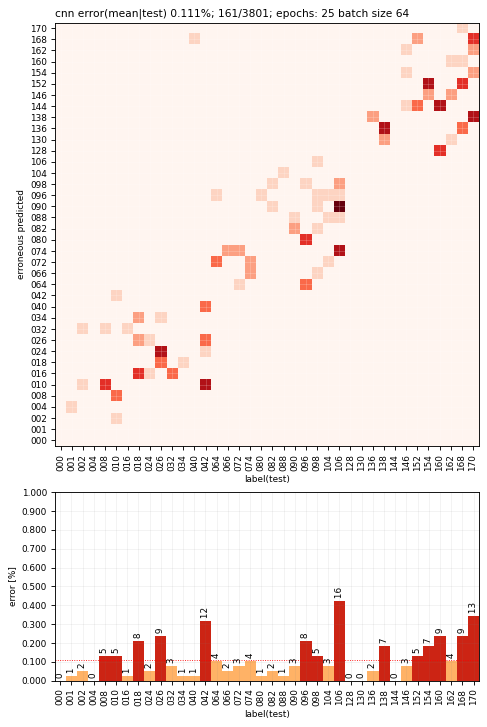

In [196]:
U = np.zeros((u_len,u_len))
for i in range(u_len):
  ii = np.where(i==c_test)[0]
  uj,uc = np.unique(c_pred[ii[np.where(c_pred[ii]!=c_test[ii])]],return_counts=True)  
  U[uj,i] = uc

from matplotlib.colors import LinearSegmentedColormap

cmap = plt.cm.Reds
uu = np.unique(U)
urange = np.linspace(0,1,num=len(uu),endpoint=True)
ucolors = [(c,cmap(c)) for c in urange]
umap = LinearSegmentedColormap.from_list("umap",ucolors, N=len(uu))

# ----------------------------

ticks = np.arange(u_len)
ticklabels = ["%03d"%(label_index[n]) for n in ticks]

plt.rcParams["font.size"] = 8
plt.rcParams["figure.dpi"] = 80

nrows,ncols = 3,1

fig = plt.figure(figsize=[6,9], dpi=plt.rcParams["figure.dpi"])
ax = plt.subplot2grid(shape=(nrows,ncols),loc=(0,0),rowspan=2,fig=fig)

map = ax.imshow(U,origin="lower",cmap=umap)

lim = [ticks[0]-2,ticks[-1]+2]

ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels,rotation=90)
ax.set_yticks(ticks)
ax.set_yticklabels(ticklabels)

ax.grid(color="white",alpha=0.2)

ax.set_xlabel("label(test)")
ax.set_ylabel("erroneous predicted")

ax.set_title("cnn error(mean|test) %.3f%%; %d/%d; epochs: %d batch size %d"%(hh_limit,hh["false"].sum(),hh["true"].sum()+hh["false"].sum(),epochs,batch_size),x=0,ha="left")

# ---------------------------

ax = plt.subplot2grid(shape=(nrows,ncols),loc=(2,0),rowspan=1,fig=fig)

xx = np.arange(hh.shape[0])
x5 = xx[i5]

xticks = xx.copy()
xticklabels = ["%03d"%(label_index[i]) for i in xticks]

yticks = np.linspace(0,1.,num=11)
yticklabels = ["%.3f"%(tick) for tick in yticks]

w_ = 1.
ax.bar(xx,height=hh["limit"],color=(1,127/255,0,1),width=w_,alpha=0.6)
ax.bar(x5,height=hh.loc[i5,"limit"],color=(192/255,0,0,1),width=w_,alpha=.8)

for i,c in enumerate(hh["false"]):
  ax.annotate(" %d "%(c),xy=(i,hh.loc[i,"limit"]),rotation=90,ha="center",va="bottom",color="black")

ax.axhline(y=hh_limit,lw=0.8,linestyle=":",color="red")

ax.set_xlabel("label(test)")
ax.set_ylabel("error [%]")

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation=90)

ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels,rotation=0)

ax.set_xlim([xticks[0]-w_/2,xticks[-1]+w_/2.])

ax.grid(alpha=0.1,color="gray")

plt.tight_layout(pad=0.5)
f_savefig(os.path.join(fresult,"%s.model.error.samples.map.png"%(fprefix)),fmetadata,gshow=True)

In [42]:
# evaluate train data

y_model = model.predict(X_train)
c_model = np.argmax(y_model,axis=1)

951/951 [==============================] - 9s 9ms/step


In [43]:
# t-SNE aproach to detect outlier

import time
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

mload = True
mpath = os.path.join(os.getcwd(),"model","wisa.net.%s.%s.%d.h5"%(fprefix,fversion,epochs))

if mload:

    embedding = np.load(mpath+".sne.embeddings.npy",allow_pickle=True)
    params = np.load(mpath+".sne.params.npy",allow_pickle=True).item()
    
else:

    t = time.time()

    sne = TSNE(
        
        n_components=2,

        learning_rate='auto',
        early_exaggeration=10,
        n_iter=1000,
        perplexity=20,

        random_state=42,
        init="pca",    
        verbose=0

        ).fit(y_model)

    embedding = sne.embedding_.copy()

    params = {k:sne.get_params()[k] for k in ['perplexity','early_exaggeration','init','method','n_iter']}
    params["kl_divergence"] = np.round(sne.kl_divergence_,3)
    params["delay"] = np.round(time.time()-t,3)

    np.save(mpath+".sne.embeddings",embedding)
    np.save(mpath+".sne.params",params)

title = "|".join(["%s:%s"%(k,params[k]) for k in params.keys()])
print(title)


perplexity:20|early_exaggeration:10|init:pca|method:barnes_hut|n_iter:1000|kl_divergence:0.8|delay:181.396


In [297]:
def calinski_harabasz_score_(X, labels):

  from sklearn.preprocessing import LabelEncoder

  le = LabelEncoder()
  labels = le.fit_transform(labels)

  n_samples, _ = X.shape
  n_labels = len(le.classes_)

  extra_disp, intra_disp = 0.0, 0.0
  mean = np.mean(X, axis=0)
  for k in range(n_labels):
      cluster_k = X[labels == k]
      mean_k = np.mean(cluster_k, axis=0)
      extra_disp += len(cluster_k) * np.sum((mean_k - mean) ** 2)
      intra_disp += np.sum((cluster_k - mean_k) ** 2)

  return (
      1.0
      if intra_disp == 0.0
      else extra_disp * (n_samples - n_labels) / (intra_disp * (n_labels - 1.0))
  )



from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score,davies_bouldin_score,calinski_harabasz_score
from sklearn.preprocessing import StandardScaler

sca = StandardScaler()
oe = embedding.copy()

u_index = assemblies.groupby(by=["type"])["number_index"].apply(list).reset_index()

n_bin = 48
n_min_samples = 15

nn = []
for n in [u_index.loc[u_index["type"]==t,"number_index"] for t in types]: nn = nn + n.to_numpy()[0]

items = dict()

dbs_scores = []

for n in nn:

  t = assemblies.loc[assemblies["number_index"]==n,"type"].to_numpy()[0]

  i_ = np.argwhere(c_model==n)
  ee = oe[i_,:].reshape(i_.shape[0],oe.shape[-1])

  ee = sca.fit_transform(ee)
  dbs = DBSCAN(
      min_samples=n_min_samples
    ).fit(ee)

  ll = dbs.labels_

  if len(np.unique(ll))!=1:
    dbs_scores.append(dict(
      n=n,
      t=t,
      lb=np.unique(ll),
      sc=silhouette_score(ee,ll),
      db=davies_bouldin_score(ee,ll),
      ch=calinski_harabasz_score_(ee,ll)
      ))
  else:
    dbs_scores.append(dict(
      n=n,
      t=t,
      lb=np.unique(ll),
      sc=np.NaN,
      db=np.NaN,
      ch=np.NaN
      ))
  
  cc = dict()
  
  for l in np.unique(ll):
    
    il = np.argwhere(dbs.labels_==l)    
    ic = i_[il].ravel()
    I_ = X_train[ic[:n_bin],:,:].reshape(-1,52,52)

    ss = []
    for i in range(I_.shape[0]):
      sample = I_[i,:,:]  
      pips, density = np.unique(sample,return_counts=True)
      ss.append(
          dict(
              type=t,
              number=label_index[n],
              sample=sample.copy(),
              density=np.abs(density[-1]-density[-2])/np.sum(density),
          )
      )

    ss = pd.DataFrame(ss)

    cc[l] = dict(
        samples=ss.copy(),
        index=il.copy()
      )

  items[n] = dict(
    cc=cc,
    ee=ee,
    ii=i_,
    dd=np.unique(ll,return_counts=True)[1]
  )

dbs_scores = pd.DataFrame(dbs_scores)

In [298]:
dbs_scores[["sc","db","ch"]].mean()

sc      0.752846
db      0.522211
ch    187.848532
dtype: float64

In [299]:
dbs_scores

,n,t,lb,sc,db,ch
0,0,0,"[0, 1]",0.751885,0.398314,907.410916
1,1,1,"[-1, 0, 1, 2, 3]",0.747515,1.177416,282.895141
2,2,1,[0],NaN,NaN,NaN
3,3,1,"[-1, 0]",0.883912,0.264793,191.920028
4,4,1,[0],NaN,NaN,NaN
5,6,1,[0],NaN,NaN,NaN
6,10,1,"[-1, 0]",0.869001,0.099371,600.266634
7,14,1,[0],NaN,NaN,NaN
8,26,1,[0],NaN,NaN,NaN
9,5,2,"[-1, 0]",0.512631,0.585208,26.358602


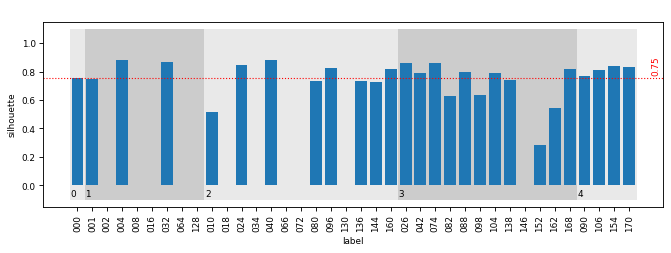

In [303]:
plt.rcParams["font.size"] = 8
plt.rcParams["figure.dpi"] = 80

ncols = 1
nrows = 1

fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=[10*ncols,3*nrows])

y = dbs_scores["sc"].to_numpy().copy()
ym = np.mean(y[~np.isnan(y)])

y_min = y[~np.isnan(y)].min()
y_max = y[~np.isnan(y)].max()

y[np.isnan(y)] = 0

xticklabels = ["%03d"%(label_index[n]) for n in nn]
xticks = np.arange(len(nn))

ax.bar(xticks,y)
ax.axhline(y=ym,color="red",linestyle=":",linewidth=1)
ax.annotate("%.2f"%(ym),xy=(len(nn)+.5,y[0]*1.05),rotation=90,color="red")

size = dbs_scores.groupby(by=["t"]).agg({"n":"count"}).to_dict()["n"]
xy,h = [-.5,-.1],1.2
a,z = .2,-1
for k in size.keys():
    w = size[k]
    ax.add_patch(Rectangle(xy=xy,width=w,height=h,alpha=a,zorder=z,color=plt.cm.Greys(0.5*(k%2+1)),antialiased=False,linewidth=0))
    ax.annotate("%d"%(k),xy=(xy[0]+.04,xy[1]+.025))
    xy[0] = xy[0] + w

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation=90)

ax.set_title(" ",x=0,ha="left")

ax.set_xlabel("label")
ax.set_ylabel("silhouette")

ax.set_ylim([-.15,1.15])

plt.show()
plt.close()

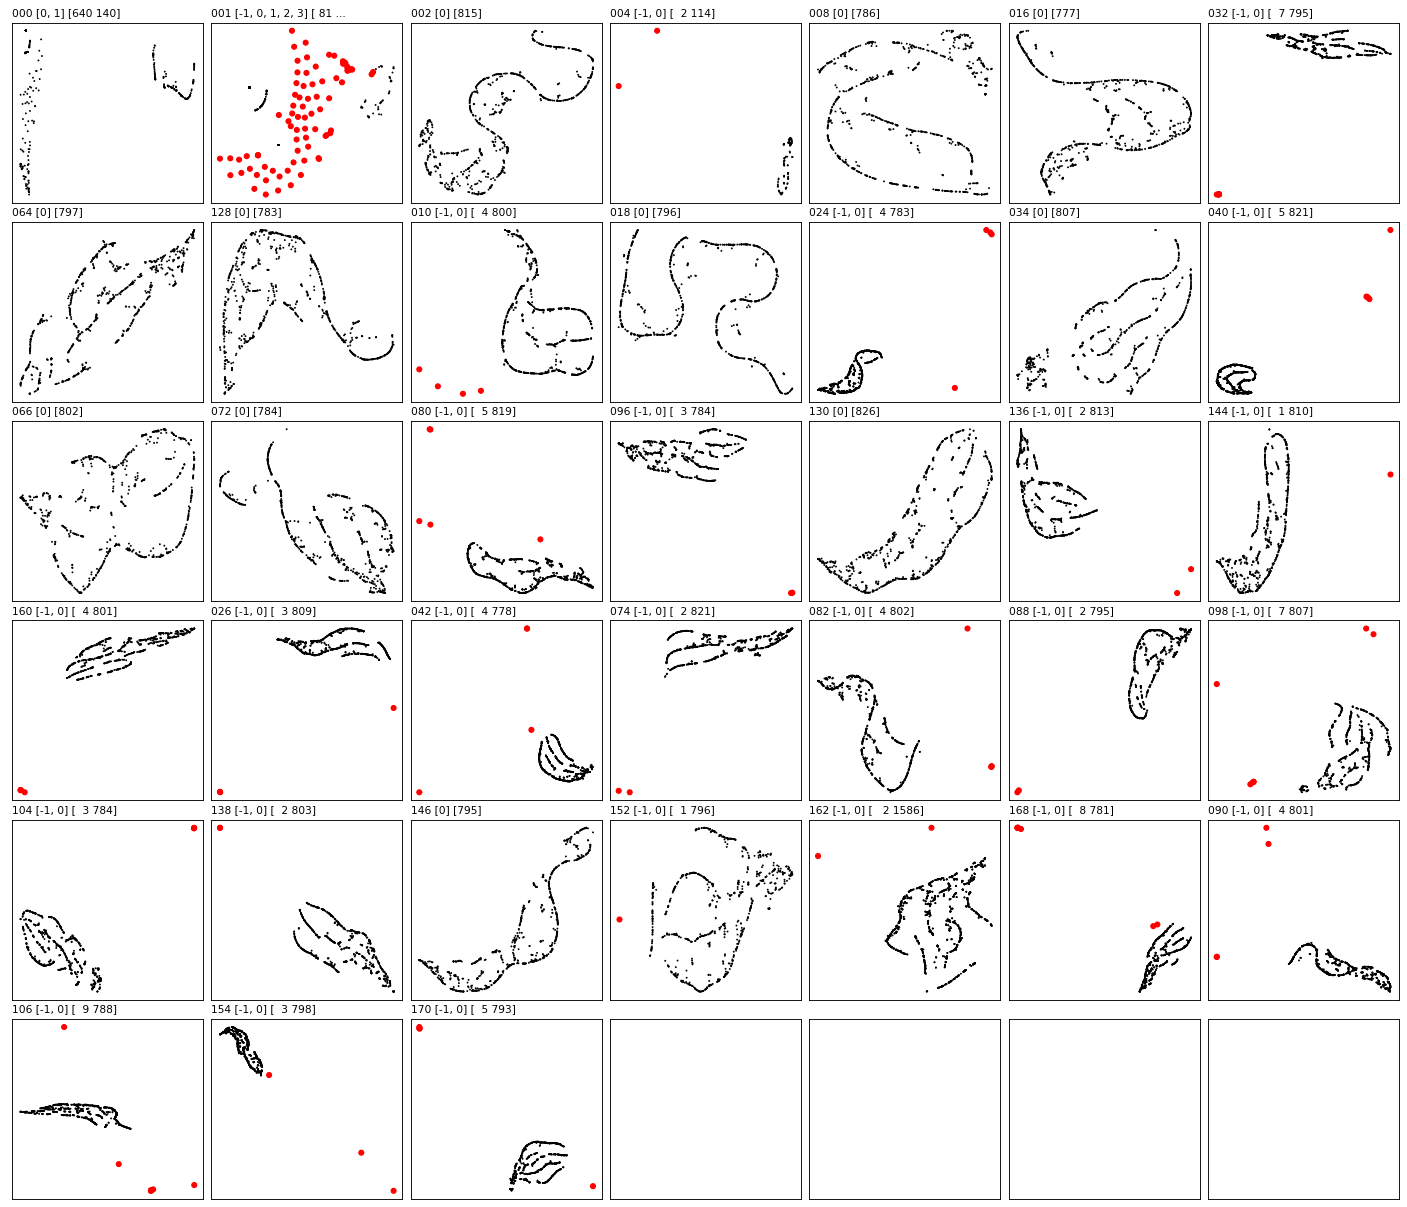

In [127]:
  
def plot_typed_sne_(items,n,ax):

  t = assemblies.loc[assemblies["number_index"]==n,"type"].to_numpy()[0]

  item = items[n]

  cc = item["cc"]
  ee = item["ee"]
  dd = item["dd"]

  for k in cc.keys():  

      i_ = cc[k]["index"]
      x_ = ee[i_,0]
      y_ = ee[i_,1]
      c_ = [("black" if k>-1 else "red")]*len(i_)
      m_ = "." if k>-1 else "o"
      s_ = 2 if k>-1 else 20

      ax.scatter(x=x_,y=y_,c=c_,s=s_,marker=m_)
      
      cm = x_.mean(),y_.mean()
      
  title = ("%03d %s %s"%(label_index[n],list(cc.keys()),dd))
  title = "%s ..."%(title[:25]) if len(title)>25 else title
  ax.set_title(title,x=0,ha="left")

# ---------------------------  

n_cmp = [plt.cm.Greys,plt.cm.Blues,plt.cm.Purples,plt.cm.Greens,plt.cm.Oranges]

plt.rcParams["font.size"] = 8
plt.rcParams["figure.dpi"] = 80

ncols = 7
nrows = int(np.ceil(len(items)/ncols))

nsize = 2.5
fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=[nsize*ncols,nsize*nrows],dpi=plt.rcParams["figure.dpi"])

i,j = 0,0
for n in nn[:]:
    
  plot_typed_sne_(items,n,ax[j,i])

  i = i+1 if i+1<ncols else 0
  j = j+1 if i==0 else j

for a in ax.ravel():
  a.tick_params(which="both",bottom=False)
  a.set_xticks([])
  a.set_yticks([])

plt.tight_layout(pad=0.5)
f_savefig(os.path.join(fresult,"%s.model.train.outlier.png"%(fprefix)),fmetadata,gshow=True)


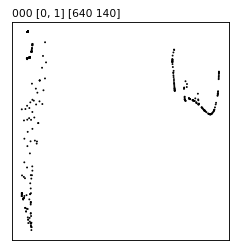

In [153]:
plt.rcParams["font.size"] = 8
plt.rcParams["figure.dpi"] = 80

nn_ = [nn[0]]
# nn_ = [nn[9],nn[11],nn[31]]

ncols = len(nn_)
nrows = 1

fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=[3.*ncols,3.15*nrows],dpi=plt.rcParams["figure.dpi"])

if 1==ncols: ax = np.array([ax])

for i,n in enumerate(nn_):
  plot_typed_sne_(items,n,ax[i])

for a in ax.ravel():
  a.tick_params(which="both",bottom=False)
  a.set_xticks([])
  a.set_yticks([])

plt.tight_layout()
plt.show()
plt.close()

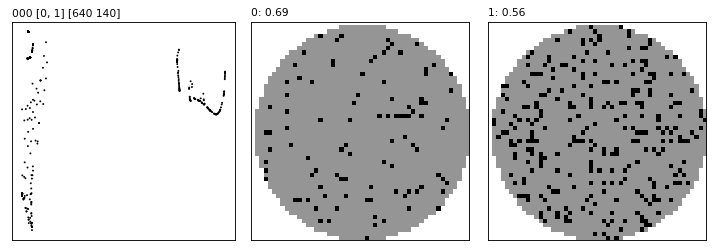

In [279]:
n = 0
item = items[n]

cc = item["cc"]
ee = item["ee"]
dd = item["dd"]

plt.rcParams["font.size"] = 8
plt.rcParams["figure.dpi"] = 80

ncols = 1+len(cc)
nrows = 1

fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=[3.*ncols,3.15*nrows],dpi=plt.rcParams["figure.dpi"])

plot_typed_sne_(items,0,ax[0])

for i in cc:

  c_ = cc[i]

  loc = 10
  i_ = c_["samples"].iloc[loc]

  ax[i+1].imshow(i_["sample"],cmap=plt.cm.Greys)
  ax[i+1].set_title("%d: %.2f"%(i,i_["density"]),x=0,ha="left")

for a in ax.ravel():
  a.tick_params(which="both",bottom=False)
  a.set_xticks([])
  a.set_yticks([])

plt.tight_layout()
plt.show()
plt.close()


In [64]:
# detect and plot outlier by DBSCAN -1 class

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

sca = StandardScaler()
oe = embedding.copy()

u_index = assemblies.groupby(by=["type"])["number_index"].apply(list).reset_index()
nn = []
for n in [u_index.loc[u_index["type"]==t,"number_index"] for t in types]: nn = nn + n.to_numpy()[0]

outlier = dict()

for n in nn:

  i_ = np.argwhere(c_model==n)
  ee = oe[i_,:].reshape(i_.shape[0],oe.shape[-1])

  ee = sca.fit_transform(ee)
  dbs = DBSCAN(
      min_samples=n_min_samples
    ).fit(ee)
  
  ll = dbs.labels_
  
  outlier[n] = i_[np.argwhere(ll==-1)]

  if (len(outlier[n])>0):

    samples = []
    
    t = assemblies.loc[assemblies["number_index"]==n,"type"].to_numpy()[0]
 
    I_ = X_train[outlier[n].ravel(),:,:].reshape(-1,52,52)

    for i in range(I_.shape[0]):
      sample = I_[i,:,:]  
      samples.append(
        dict(
            type=t,
            number=label_index[n],
            sample=sample
        )
      )

    samples = pd.DataFrame(samples)
    plot_items_(samples,fpath="sne",fpostfix="o.%03d"%(label_index[n]))


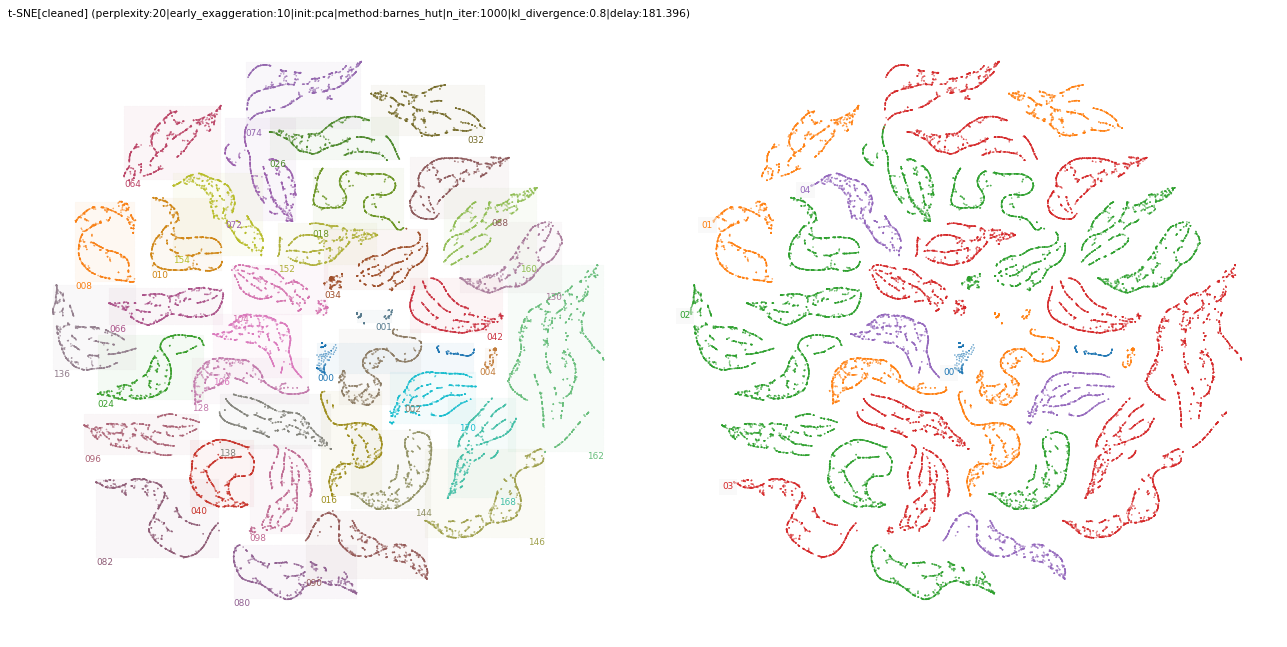

In [66]:
# plot t-sne pattern

c_num = y_model.shape[1]

cmap = plt.cm.tab10

urange = np.linspace(0.,1,num=cmap.N,endpoint=True)
ucolors = [(c,cmap(c)) for c in urange]
umap = LinearSegmentedColormap.from_list("umap",ucolors,N=c_num)

u_index = assemblies.groupby(by=["type"])["number_index"].apply(list).reset_index()
u_labels = c_model.copy()

u_hue = np.zeros((embedding.shape[0],4))
for n in range(c_num): 
  u_hue[np.argwhere(u_labels==n)] = umap(n)

# ---------------------------

plt.rcParams["font.size"] = 8
plt.rcParams["figure.dpi"] = 80

nrows,ncols = 1,2
nsize = 8
fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=[nsize*ncols,nsize*nrows],dpi=plt.rcParams["figure.dpi"])

# ---------------------------

nn = []
for n in [u_index.loc[u_index["type"]==t,"number_index"] for t in types]: nn = nn + n.to_numpy()[0]

tt = {t:[] for t in types}

for n in nn[:]:
    
  i_ = np.argwhere(c_model==n).flatten()
  
  # outlier removal
  o_ = outlier[n].flatten()
  if len(o_)>0:
    i_ = i_[~np.isin(i_,o_)]

  xy_ = embedding[i_,:].reshape(i_.shape[0],embedding.shape[-1])
  x_,y_ = xy_[:,0],xy_[:,1]    
  c_ = u_hue[i_].reshape(i_.shape[0],4)
  
  n_ = "%03d"%(label_index[n])
  
  ax[0].scatter(x=x_,y=y_,c=c_,s=.1,alpha=1.) 
  
  patch = Rectangle(
    xy=(x_.min(),y_.min()),width=x_.max()-x_.min(),height=y_.max()-y_.min(),angle=0,
    alpha=0.05,facecolor=c_[0],fill=True,
    antialiased=True,zorder=-1,
    edgecolor=c_[0],linewidth=0.1,linestyle="--"
  )
  ax[0].add_patch(patch)
  
  cm = patch.xy if patch.xy[0]<0 else (patch.xy[0]+patch.get_width(),patch.xy[1])
  ax[0].annotate(n_,xy=cm,va="top",ha="left" if patch.xy[0]<0 else "right",color=c_[0],rotation=0)

  t = assemblies.loc[assemblies["number_index"]==n,"type"].to_numpy()[0]
  tt[t] = tt[t] + list(i_.flatten())

ax[0].set_title("t-SNE[cleaned] (%s)"%(title),x=0,ha="left")

# ---------------------------

for t in types:
  n_ = "%02d"%(t)
  i_ = tt[t]
  c_ = [plt.cm.tab10.colors[t]]*len(i_)  
  x_,y_ = embedding[i_,0],embedding[i_,1],
  ax[1].scatter(x=x_,y=y_,c=c_,s=.1)

  i_ = np.argmin(x_)
  cm = np.array([x_[i_],y_[i_]]).flatten().round(2)
  ax[1].text(cm[0],cm[1],n_,ha="right",va="top",color=c_[0],bbox=dict(boxstyle="square,pad=0.4",fc="whitesmoke",ec=c_[0],lw=0,alpha=.5))

for a in ax.ravel():
  a.set_axis_off()
  a.set_xlim([-150,150])
  a.set_ylim([-150,150])

plt.tight_layout(pad=.5)
f_savefig(os.path.join(fresult,"%s.model.train.sne.png"%(fprefix)),fmetadata,gshow=True)


In [67]:
import time 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sca = StandardScaler()
pe = sca.fit_transform(y_model)
pe = PCA(
        n_components=2
        ,random_state=42
      ).fit_transform(pe)

# ---------------------------

c_num = y_model.shape[1]

cmap = plt.cm.tab10

urange = np.linspace(0.,1,num=cmap.N,endpoint=True)
ucolors = [(c,cmap(c)) for c in urange]
umap = LinearSegmentedColormap.from_list("umap",ucolors,N=c_num)

u_index = assemblies.groupby(by=["type"])["number_index"].apply(list).reset_index()
u_labels = c_model.copy()

u_hue = np.zeros((embedding.shape[0],4))
for n in range(c_num): 
  u_hue[np.argwhere(u_labels==n)] = umap(n)

nn = []
for n in [u_index.loc[u_index["type"]==t,"number_index"] for t in types]: nn = nn + n.to_numpy()[0]

# ---------------------------

plt.rcParams["font.size"] = 8
plt.rcParams["figure.dpi"] = 200

ncols = 2
nrows = 1

nsize = 8
fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=[nsize*ncols,nsize*nrows],dpi=plt.rcParams["figure.dpi"])

tt = {t:[] for t in types}

for n in nn[:]:
  
  i_ = np.argwhere(c_model==n).flatten()

  xy_ = pe[i_,:].reshape(i_.shape[0],pe.shape[-1])
  x_,y_ = xy_[:,0],xy_[:,1]    
  c_ = u_hue[i_].reshape(i_.shape[0],4)
   
  ax[0].scatter(x=x_,y=y_,c=c_,s=.8,alpha=1.)

  n_ = "%03d"%(label_index[n])
  cm = xy_.mean(axis=0)

  ax[0].annotate(n_,xy=cm,ha=("right" if cm[0]<0 else "left"),va=("top" if cm[1]<0 else "bottom"),color=c_[0])

  t = assemblies.loc[assemblies["number_index"]==n,"type"].to_numpy()[0]
  tt[t] = tt[t] + list(i_.flatten())

ax[0].set_title("PCA[full]",x=0,ha="left")
  
#for i, (comp, var) in enumerate(zip(pca.components_, pca.explained_variance_)):
#    print(i,comp,var)
#    comp = comp  * var # scale component by its variance explanation power
#    ax.plot(
#        [0, comp[0]],
#        [0, comp[1]],
#        label=f"Component {i}",
#        linewidth=1,
#        color=f"C{i + 2}",
#    )

# ---------------------------

for t in types:
  n_ = "%02d"%(t)
  i_ = tt[t]
  c_ = [plt.cm.tab10.colors[t]]*len(i_)
  xy_ = pe[i_,:]
  x_,y_ = xy_[:,0],xy_[:,1]    
  ax[1].scatter(x=x_,y=y_,c=c_,s=.1)

  i_ = np.argmin(x_)
  cm = np.array([x_[i_],y_[i_]]).flatten().round(2)
  ax[1].text(cm[0],cm[1],n_,ha="right",va="top",color=c_[0],bbox=dict(boxstyle="square,pad=0.4",fc="whitesmoke",ec=c_[0],lw=0,alpha=.5))

for a in ax.ravel():
  a.set_axis_off()

f_savefig(os.path.join(fresult,"%s.model.train.pca.png"%(fprefix)),fmetadata,gshow=False)

In [31]:
# samples class preview

for n in nn[:]:
  t = assemblies.loc[assemblies["number_index"]==n,"type"].to_numpy()[0]
  item = items[n]
  cc = item["cc"]
  for k in cc.keys():
    samples = cc[k]["samples"]
    plot_items_(samples,fpath="dbg",fpostfix="%02d_%03d_%d"%(t,label_index[n],k),fshow=False)

In [ ]:

# ----------------------------------------------

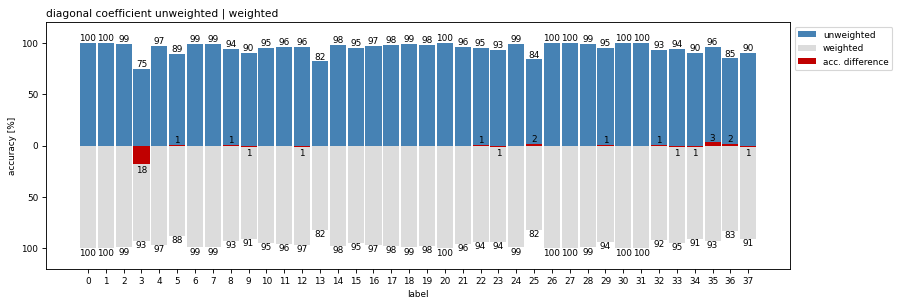

In [104]:
hup = C.diagonal().round(0)
hdw = -Cw.diagonal().round(0)
hdd = (hup+hdw).round(0)

plt.rcParams["font.size"] = 8
plt.rcParams["figure.dpi"] = 80

ncols,nrows = 1,1
nwidth,nheight = 12,4
fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=[nwidth*ncols,nheight*nrows],dpi=plt.rcParams["figure.dpi"])

xticks = np.arange(num_classes)

cc = [
  (70/255,130/255,180/255,1),   #steelblue
  (220/255,220/255,220/255,1),  #gainsboro
  (192/255,0,0,1)               #red
]

w_ = .9
ax.bar(xticks,height=hup,width=w_,color=cc[0],label="unweighted")
ax.bar(xticks,height=hdw,width=w_,color=cc[1],label="weighted")
ax.bar(xticks,height=hdd,width=w_,color=cc[2],label="acc. difference")

ax.set_xticks(xticks)
#ax.set_xlim([xticks[0]-.5,xticks[-1]+.5])
ax.set_ylim([hdw.min()*1.2,hup.max()*1.2])

ax.set_yticklabels(["%d"%(np.abs(t)) for t in ax.get_yticks()])

ax.set_title("diagonal coefficient unweighted | weighted",x=0,ha="left")
ax.set_xlabel("label")
ax.set_ylabel("accuracy [%]")

for i,h in enumerate(zip(hup,hdw,hdd)):
  ax.annotate("%.0f"%(h[0]),xy=(i,h[0]),va="bottom",ha="center",rotation=0)
  ax.annotate("%.0f"%(np.abs(h[1])),xy=(i,h[1]),va="top",ha="center",rotation=0)
  if h[2]!=0:
    ax.annotate("%.0f"%(np.abs(h[2])),xy=(i,h[2] + (0. if h[2]>0 else -2)),va="top" if h[2]<0 else "bottom",ha="center",rotation=0)

ax.legend(bbox_to_anchor=(1.,1),title="")

f_savefig(os.path.join(fresult,"%s.label.weight.unweight.png"%(fprefix)),fmetadata,gshow=True)


In [ ]:

# ----------------------------------------------

In [78]:
kap = tfa.metrics.CohenKappa(num_classes=num_classes)

cma = tfa.metrics.MultiLabelConfusionMatrix(num_classes=num_classes)
_ = cma.update_state(y_test,y_pred)
_ = kap.update_state(y_test,y_pred)

# kap.result(),cma.result()


In [91]:

def kappa_(R):
  n = np.sum(R)
  n0 = R.diagonal().sum()
  nc = np.sum(R.sum(axis=0) * R.sum(axis=1) / n)
  return (n0-nc)/(n-nc)

def confusion_matrix_(c1,c2):
  C = np.zeros((num_classes,num_classes))
  for j in range(num_classes):
    for i in range(num_classes):
      C[j,i] = np.sum((c1==j)&(c2==i))
  return C

k_true = y_valid.copy()
k_pred = model.predict(X_valid,batch_size=batch_size,verbose=1)

c1 = np.argmax(k_true,axis=1).astype(np.int32)
c2 = np.argmax(k_pred,axis=1).astype(np.int32)

C = confusion_matrix_(c1,c2)
print(kappa_(C))

"""

plt.rcParams["font.size"] = 8
plt.rcParams["figure.dpi"] = 80

ncols,nrows = 1,1
nwidth,nheight = 8,8
fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=[nwidth*ncols,nheight*nrows],dpi=plt.rcParams["figure.dpi"])

ax.imshow(C,cmap=plt.cm.Reds)

plt.show()
plt.close()
"""

history["val_kap"][-1],history["kap"][-1]



60/60 [==============================] - 1s 18ms/step
0.9507691475824935


(0.9507691264152527, 0.9757237434387207)